**1. Import Necessary Libraries**

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

# Model selection
from sklearn.model_selection import train_test_split

# Model training and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score
)

# Other utilities
from itertools import product

**2. Load the Dataset**

In [2]:
# Load the dataset with error handling
try:
    file_path = '/kaggle/input/dataset/RTA Data 2020 to July 2023.xlsx'
    df = pd.read_excel(file_path, engine='openpyxl')
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The file was not found.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Dataset loaded successfully.


**3. Initial Data Inspection**

In [3]:
def initial_data_inspection(df):
    # Basic Overview
    print("First 5 rows:")
    display(df.head())

    print("\nData Summary and Types:")
    df.info()

    # Summary statistics for numerical columns
    print("\nSummary Statistics for Numerical Columns:")
    numeric_columns = df.select_dtypes(include=['number'])
    display(numeric_columns.describe())

    # Summary statistics for categorical columns
    print("\nSummary Statistics for Categorical Columns:")
    categorical_columns = df.select_dtypes(include=['object', 'category'])
    display(categorical_columns.describe())

    # Check for missing values
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    print("\nMissing Values and Percentage:")
    missing_summary = pd.DataFrame({
        'Missing Values': missing_values,
        'Percentage': missing_percentage
    }).sort_values(by='Percentage', ascending=False)
    display(missing_summary)

    # Cardinality of categorical features
    print("\nCardinality of Categorical Columns:")
    unique_values = df.nunique()
    display(unique_values.sort_values(ascending=False))

    # Value counts for categorical columns with few unique values
    for col in categorical_columns:
        if df[col].nunique() < 10:
            print(f"\nValue Counts for {col}:")
            display(df[col].value_counts())

    # Check for duplicate rows
    num_duplicates = df.duplicated().sum()
    if num_duplicates > 0:
        print(f"\nNumber of Duplicate Rows in Dataset: {num_duplicates}")
    else:
        print("\nNo Duplicate Rows Found in Dataset.")

    # Inspect data types and potential conversions
    print("\nColumns with Potential Data Type Issues:")
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                pd.to_numeric(df[col])
                print(f"Column '{col}' can potentially be converted to a numeric type.")
            except ValueError:
                continue

# Call the function for DataFrame
initial_data_inspection(df)

First 5 rows:


,EcYear,EcNumber,CallTime,EmergencyArea,TotalPatientsInEmergency,Gender,Age,HospitalName,Reason,responsetime,...,BikesInvolved,BusesInvolved,CarsInvolved,CartInvovled,RickshawsInvolved,TractorInvovled,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved
0,2020,31486,2020-12-31 22:41:47,NEAR APS SCHOOL FORT ROAD RWP,1,Male,27.0,BBH,Bike Slip,10.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020,31485,2020-12-31 22:25:00,"Infront of Daig.com, Near Dha gate 2, gt road...",1,Male,20.0,NaN,Car hit Footpath,12.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020,31483,2020-12-31 21:54:59,Muhammadi chowk arshad bakery khyaban e sirsye...,1,Male,48.0,BBH,Rickshaw hit with Car,10.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2020,31482,2020-12-31 21:24:22,"Gulzar e quaid, T/W Katcheri Near Attock Pump,...",1,Male,45.0,NaN,Car hit Car and runaway,5.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020,31479,2020-12-31 21:03:49,Taaj Company Gawalmandi Chowk Liaqat Baag Road...,1,Male,22.0,NaN,Unknown Bike hit Bike and runaway,5.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



Data Summary and Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46189 entries, 0 to 46188
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   EcYear                    46189 non-null  object        
 1   EcNumber                  38978 non-null  object        
 2   CallTime                  40233 non-null  datetime64[ns]
 3   EmergencyArea             46188 non-null  object        
 4   TotalPatientsInEmergency  46189 non-null  object        
 5   Gender                    46188 non-null  object        
 6   Age                       46188 non-null  float64       
 7   HospitalName              24239 non-null  object        
 8   Reason                    46188 non-null  object        
 9   responsetime              46184 non-null  float64       
 10  EducationTitle            46188 non-null  object        
 11  InjuryType                46187 non-null  object       

,Age,responsetime,BicycleInvovled,BikesInvolved,BusesInvolved,CarsInvolved,CartInvovled,RickshawsInvolved,TractorInvovled,TrainsInvovled,TrucksInvolved,VansInvolved,OthersInvolved
count,46188.000000,46184.000000,46187.000000,46187.000000,46187.000000,46187.000000,46187.000000,46187.000000,46187.000000,46187.000000,46187.000000,46187.000000,46187.000000
mean,32.447129,6.256106,0.008725,0.967242,0.009202,0.234049,0.001970,0.087297,0.009830,0.002208,0.044948,0.117392,0.009656
std,15.176229,4.901342,0.093467,0.578776,0.100349,0.448054,0.044344,0.289319,0.098657,0.046942,0.220947,0.334686,0.098893
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,29.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,42.000000,8.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,118.000000,101.000000,2.000000,10.000000,2.000000,5.000000,1.000000,2.000000,1.000000,1.000000,3.000000,4.000000,2.000000



Summary Statistics for Categorical Columns:


,EcYear,EcNumber,EmergencyArea,TotalPatientsInEmergency,Gender,HospitalName,Reason,EducationTitle,InjuryType,Cause,PatientStatus
count,46189,38978,46188,46189,46188,24239,46188,46188,46187,46187,46187
unique,5,34800,37520,13,4,162,23940,9,5,7,3
top,2022,35,Railway Track Underpass Nazar Chowk Near Kach...,1,Male,BBH,same,Matric,Minor,Over Speed,Alive & unstable
freq,12902,3,42,36151,39794,6953,2328,15697,34788,29586,23788



Missing Values and Percentage:


,Missing Values,Percentage
HospitalName,21950,47.522137
EcNumber,7211,15.611942
CallTime,5956,12.894845
responsetime,5,0.010825
BicycleInvovled,2,0.004330
PatientStatus,2,0.004330
Cause,2,0.004330
InjuryType,2,0.004330
BikesInvolved,2,0.004330
TrainsInvovled,2,0.004330



Cardinality of Categorical Columns:


CallTime                    40170
EmergencyArea               37520
EcNumber                    34800
Reason                      23940
HospitalName                  162
Age                           100
responsetime                   68
TotalPatientsInEmergency       13
EducationTitle                  9
Cause                           7
CarsInvolved                    6
BikesInvolved                   5
EcYear                          5
VansInvolved                    5
InjuryType                      5
Gender                          4
TrucksInvolved                  4
BusesInvolved                   3
BicycleInvovled                 3
PatientStatus                   3
RickshawsInvolved               3
OthersInvolved                  3
CartInvovled                    2
TractorInvovled                 2
TrainsInvovled                  2
dtype: int64


Value Counts for EcYear:


EcYear
2022        12902
2021        12677
2020        11382
2023         9227
Hospital        1
Name: count, dtype: int64


Value Counts for Gender:


Gender
Male      39794
Female     6392
Other         1
0             1
Name: count, dtype: int64


Value Counts for EducationTitle:


EducationTitle
Matric          15697
Primary         11717
Illetrate       10845
Intermediate     5675
Graduation       1686
Masters           439
Middle            119
PHD                 9
0                   1
Name: count, dtype: int64


Value Counts for InjuryType:


InjuryType
Minor                 34788
Single Fracture        6737
Head Injury            3503
Multiple Fractures      778
Spinal Injury           381
Name: count, dtype: int64


Value Counts for Cause:


Cause
Over Speed      29586
Carelessness    14177
U Turn            934
Wrong Turn        841
Tyre Burst        481
Others            104
One Wheeling       64
Name: count, dtype: int64


Value Counts for PatientStatus:


PatientStatus
Alive & unstable    23788
Alive & stable      21812
Dead                  587
Name: count, dtype: int64


Number of Duplicate Rows in Dataset: 8

Columns with Potential Data Type Issues:


**4. Split the Dataset into Train, Validation, and Test Sets**

In [4]:
# Split the dataset into 60% training and 40% temporary data
train_set, temp_set = train_test_split(df, test_size=0.4, random_state=42)

# Split the temporary set into 20% validation and 20% test
validation_set, test_set = train_test_split(temp_set, test_size=0.5, random_state=42)

# Confirm the sizes of each set
print(f"Training Set Size: {len(train_set)}")
print(f"Validation Set Size: {len(validation_set)}")
print(f"Test Set Size: {len(test_set)}")     

Training Set Size: 27713
Validation Set Size: 9238
Test Set Size: 9238


**5. Data Processing**

**a. Handle Missing Values**

In [5]:
# Identify numerical and categorical columns
numeric_cols = train_set.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = train_set.select_dtypes(include=['object', 'category']).columns.tolist()

# Identify columns not included in imputation
all_cols = train_set.columns.tolist()
imputed_cols = numeric_cols + categorical_cols
remaining_cols = list(set(all_cols) - set(imputed_cols))
print("\nColumns not included in imputation:", remaining_cols)

# Handle datetime columns separately if any
datetime_cols = [col for col in remaining_cols if np.issubdtype(train_set[col].dtype, np.datetime64)]
other_cols = list(set(remaining_cols) - set(datetime_cols))

# Impute datetime columns without using inplace=True
for col in datetime_cols:
    # Fill missing values in each set with the mode of the training set for consistency
    mode_datetime = train_set[col].mode()[0]
    train_set[col] = train_set[col].fillna(mode_datetime)
    validation_set[col] = validation_set[col].fillna(mode_datetime)
    test_set[col] = test_set[col].fillna(mode_datetime)

# Add other remaining columns to categorical_cols
categorical_cols.extend(other_cols)

# Initialize imputers
numeric_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

# Fit and transform the training set
train_set[numeric_cols] = numeric_imputer.fit_transform(train_set[numeric_cols])
train_set[categorical_cols] = categorical_imputer.fit_transform(train_set[categorical_cols])

# Apply transformations to validation and test sets
validation_set[numeric_cols] = numeric_imputer.transform(validation_set[numeric_cols])
validation_set[categorical_cols] = categorical_imputer.transform(validation_set[categorical_cols])
test_set[numeric_cols] = numeric_imputer.transform(test_set[numeric_cols])
test_set[categorical_cols] = categorical_imputer.transform(test_set[categorical_cols])

# Verify missing values
print("\nTotal missing values after imputation:")
print("Training Set:", train_set.isnull().sum().sum())
print("Validation Set:", validation_set.isnull().sum().sum())
print("Test Set:", test_set.isnull().sum().sum())


Columns not included in imputation: ['CallTime']

Total missing values after imputation:
Training Set: 0
Validation Set: 0
Test Set: 0


**b. Handle Outliers**

In [6]:
# Calculate IQR and bounds from the training set
def calculate_outlier_bounds(df, columns):
    bounds = {}
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        bounds[col] = (lower_bound, upper_bound)
    return bounds

# Get bounds from the training set
outlier_bounds = calculate_outlier_bounds(train_set, numeric_cols)

# Function to apply clipping based on calculated bounds
def clip_outliers(df, bounds):
    for col, (lower, upper) in bounds.items():
        df[col] = df[col].clip(lower=lower, upper=upper)

# Apply clipping to all datasets
clip_outliers(train_set, outlier_bounds)
clip_outliers(validation_set, outlier_bounds)
clip_outliers(test_set, outlier_bounds)

**c. Feature Engineering**

In [7]:
# Extracting features from 'CallTime' column if it exists in the dataset
if 'CallTime' in train_set.columns:
    for dataset in [train_set, validation_set, test_set]:
        dataset['Year'] = pd.to_datetime(dataset['CallTime']).dt.year
        dataset['Month'] = pd.to_datetime(dataset['CallTime']).dt.month
        dataset['Day'] = pd.to_datetime(dataset['CallTime']).dt.day
        dataset['Hour'] = pd.to_datetime(dataset['CallTime']).dt.hour
    # Drop the original 'CallTime' column to prevent redundancy
    train_set.drop(columns=['CallTime'], inplace=True)
    validation_set.drop(columns=['CallTime'], inplace=True)
    test_set.drop(columns=['CallTime'], inplace=True)

**d. Handle Duplicate Rows**

In [8]:
# Remove duplicate rows in each dataset
train_set = train_set.drop_duplicates()
validation_set = validation_set.drop_duplicates()
test_set = test_set.drop_duplicates()

**e. Handle Text Features**

In [9]:
# Define synonym mapping
synonym_mapping = {
    'bike slipped': 'bike slip',
    'bike slip': 'bike slip',
    'same': 'unknown',
    'car hit the bike and runaway': 'car hit bike and runaway',
    'bike hit the pedestrian and runaway': 'bike hit pedestrian and runaway',
    'bike hit pedistarian': 'bike hit pedestrian',
    'two bikes collieds': 'two bikes collided',
    '.': 'unknown'
}

# Apply text processing on 'Reason' in each dataset
for dataset in [train_set, validation_set, test_set]:
    # Ensure 'Reason' column exists
    if 'Reason' in dataset.columns:
        # Basic text cleaning
        dataset['Reason'] = (
            dataset['Reason']
            .str.lower()
            .str.replace('[^\w\s]', '', regex=True)
            .str.strip()
        )
        # Replace synonyms
        dataset['Reason'] = dataset['Reason'].replace(synonym_mapping)

**f. Group Rare Categories Before Encoding**

In [10]:
# Re-identify categorical columns excluding target variables and 'CallTime'
categorical_cols = train_set.select_dtypes(include=['object', 'category', 'string']).columns.tolist()
categorical_cols = [col for col in categorical_cols if col not in ['InjuryType', 'PatientStatus', 'CallTime']]

print(f"Categorical Columns after re-identification: {categorical_cols}")

# **Convert all categorical columns to strings to avoid mixed data type issues**
for col in categorical_cols:
    train_set[col] = train_set[col].astype(str)
    validation_set[col] = validation_set[col].astype(str)
    test_set[col] = test_set[col].astype(str)

# Define a threshold for rare categories (e.g., categories appearing less than 1% of the time)
threshold = 0.01  # 1%

# Create a dictionary to store mappings for each column
rare_category_mappings = {}

# Identify rare categories in the training set and create a mapping
for col in categorical_cols:
    freq = train_set[col].value_counts(normalize=True)
    rare_categories = freq[freq < threshold].index.tolist()
    rare_category_mappings[col] = rare_categories
    # Replace rare categories in the training set with 'Other'
    train_set[col] = train_set[col].replace(rare_categories, 'Other')

# Apply the mapping to the validation and test sets
for col in categorical_cols:
    # Replace rare categories in validation and test sets with 'Other'
    validation_set[col] = validation_set[col].replace(rare_category_mappings[col], 'Other')
    test_set[col] = test_set[col].replace(rare_category_mappings[col], 'Other')
    # Replace categories not seen in training set with 'Other'
    known_categories = train_set[col].unique()
    validation_set[col] = validation_set[col].apply(lambda x: x if x in known_categories else 'Other')
    test_set[col] = test_set[col].apply(lambda x: x if x in known_categories else 'Other')

Categorical Columns after re-identification: ['EcYear', 'EcNumber', 'EmergencyArea', 'TotalPatientsInEmergency', 'Gender', 'HospitalName', 'Reason', 'EducationTitle', 'Cause']


**g. One Hot Encode Categorical Variables, Excluding Target Variables**

In [11]:
# Exclude target variables from categorical columns (already done, but to ensure)
categorical_cols = [col for col in categorical_cols if col not in ['InjuryType', 'PatientStatus']]

# Convert all categorical columns to strings to avoid mixed data type issues
for col in categorical_cols:
    train_set[col] = train_set[col].astype(str)
    validation_set[col] = validation_set[col].astype(str)
    test_set[col] = test_set[col].astype(str)

# One-hot encoding of categorical columns
onehot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit and transform training data, then apply to validation and test sets
train_encoded = onehot_encoder.fit_transform(train_set[categorical_cols])
validation_encoded = onehot_encoder.transform(validation_set[categorical_cols])
test_encoded = onehot_encoder.transform(test_set[categorical_cols])

# Assign column names to encoded features
encoded_feature_names = onehot_encoder.get_feature_names_out(categorical_cols)
train_encoded_df = pd.DataFrame(train_encoded, columns=encoded_feature_names)
validation_encoded_df = pd.DataFrame(validation_encoded, columns=encoded_feature_names)
test_encoded_df = pd.DataFrame(test_encoded, columns=encoded_feature_names)

# Reset the index to prepare for concatenation
train_encoded_df.reset_index(drop=True, inplace=True)
validation_encoded_df.reset_index(drop=True, inplace=True)
test_encoded_df.reset_index(drop=True, inplace=True)

# Drop the original categorical columns (excluding target variables) and concatenate the new encoded features
train_set = pd.concat([train_set.drop(columns=categorical_cols).reset_index(drop=True), train_encoded_df], axis=1)
validation_set = pd.concat([validation_set.drop(columns=categorical_cols).reset_index(drop=True), validation_encoded_df], axis=1)
test_set = pd.concat([test_set.drop(columns=categorical_cols).reset_index(drop=True), test_encoded_df], axis=1)

print(f"Number of features after encoding: {train_set.shape[1]}")

Number of features after encoding: 55


**h. Feature Scaling**

In [12]:
# Identify numerical columns (excluding target variables and one-hot encoded features)
numeric_cols_after_encoding = train_set.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols_after_encoding = [col for col in numeric_cols_after_encoding if col not in ['InjuryType', 'PatientStatus']]

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the training set only
scaler.fit(train_set[numeric_cols_after_encoding])

# Transform the training, validation, and test sets
train_set[numeric_cols_after_encoding] = scaler.transform(train_set[numeric_cols_after_encoding])
validation_set[numeric_cols_after_encoding] = scaler.transform(validation_set[numeric_cols_after_encoding])
test_set[numeric_cols_after_encoding] = scaler.transform(test_set[numeric_cols_after_encoding])

**i. Label Encode Target Variables**

In [13]:
# Create copies to avoid modifying the original data
train_set_encoded = train_set.copy()
validation_set_encoded = validation_set.copy()
test_set_encoded = test_set.copy()

# Initialize LabelEncoders
label_encoder_injury = LabelEncoder()
label_encoder_status = LabelEncoder()

# Encode 'InjuryType'
train_set_encoded['InjuryType'] = label_encoder_injury.fit_transform(train_set_encoded['InjuryType'])
validation_set_encoded['InjuryType'] = label_encoder_injury.transform(validation_set_encoded['InjuryType'])
test_set_encoded['InjuryType'] = label_encoder_injury.transform(test_set_encoded['InjuryType'])

# Encode 'PatientStatus'
train_set_encoded['PatientStatus'] = label_encoder_status.fit_transform(train_set_encoded['PatientStatus'])
validation_set_encoded['PatientStatus'] = label_encoder_status.transform(validation_set_encoded['PatientStatus'])
test_set_encoded['PatientStatus'] = label_encoder_status.transform(test_set_encoded['PatientStatus'])

# View the mapping
print("InjuryType Classes:", label_encoder_injury.classes_)
print("PatientStatus Classes:", label_encoder_status.classes_)

InjuryType Classes: ['Head Injury' 'Minor' 'Multiple Fractures' 'Single Fracture'
 'Spinal Injury']
PatientStatus Classes: ['Alive & stable' 'Alive & unstable' 'Dead']


**10. Model Training and Evaluation**

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STO

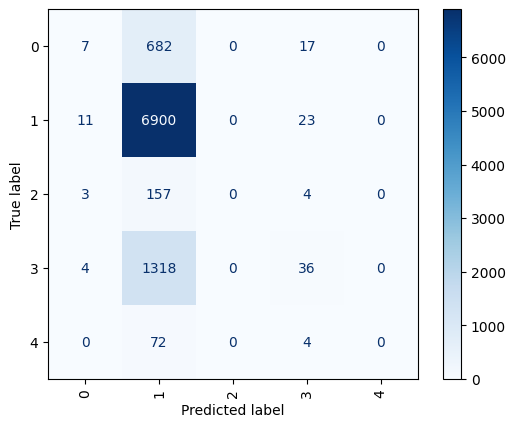

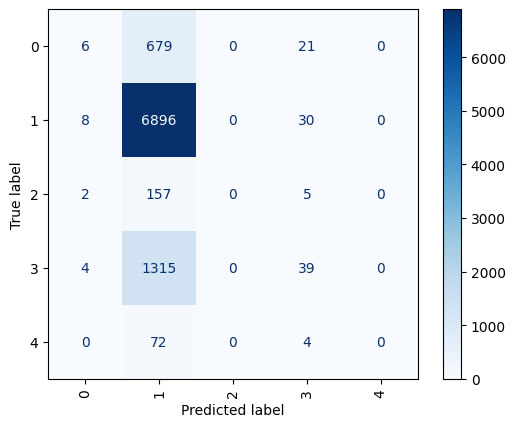

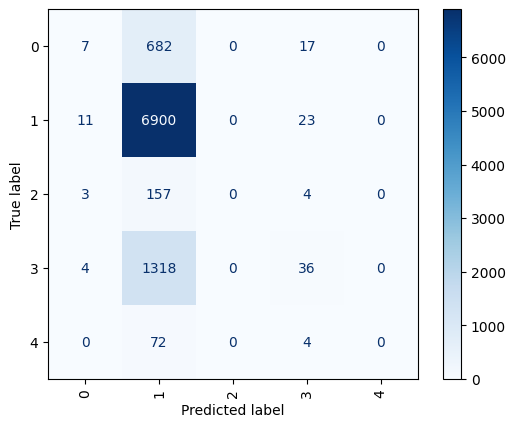

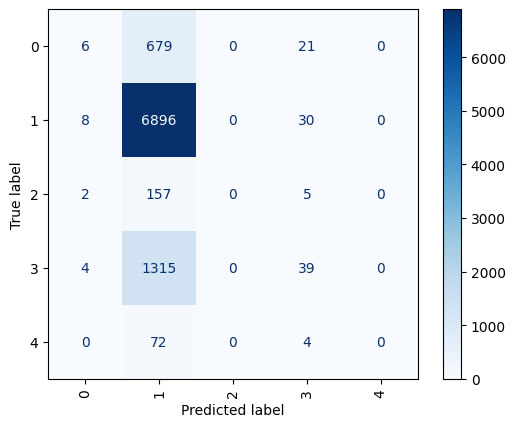

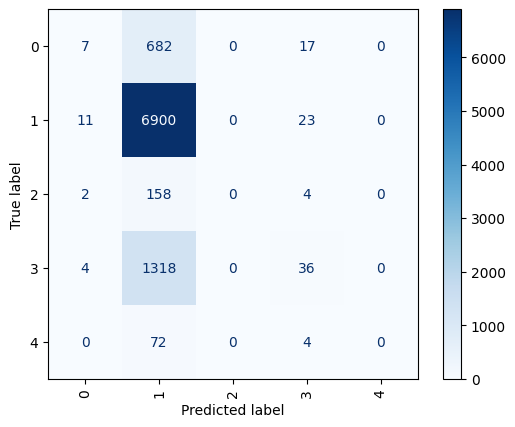

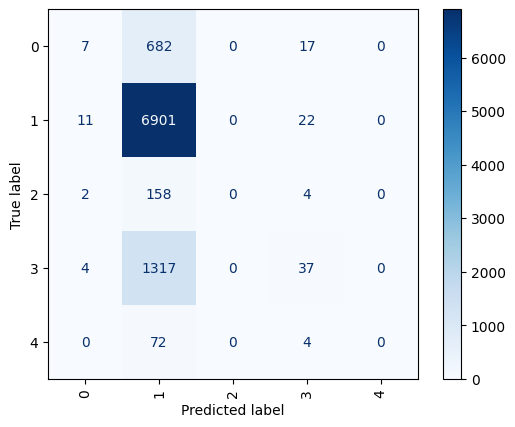

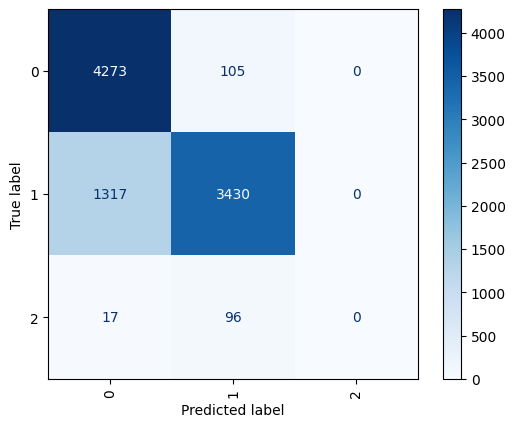

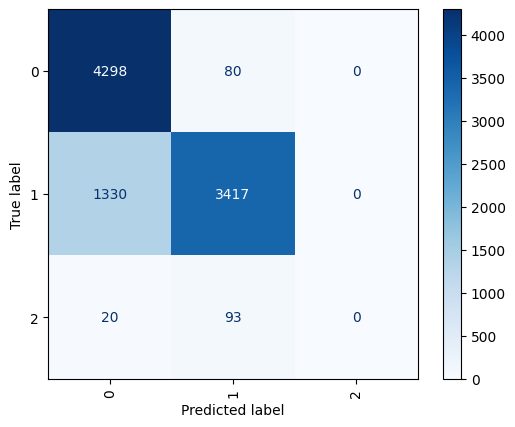

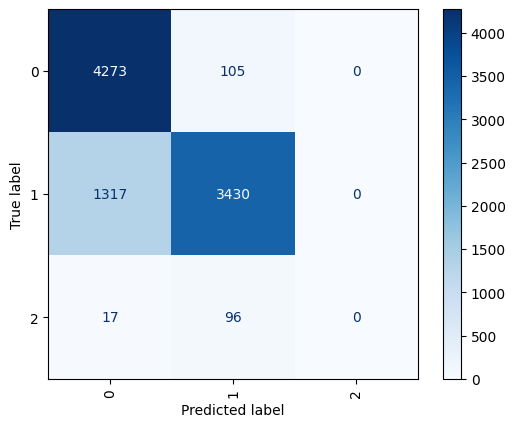

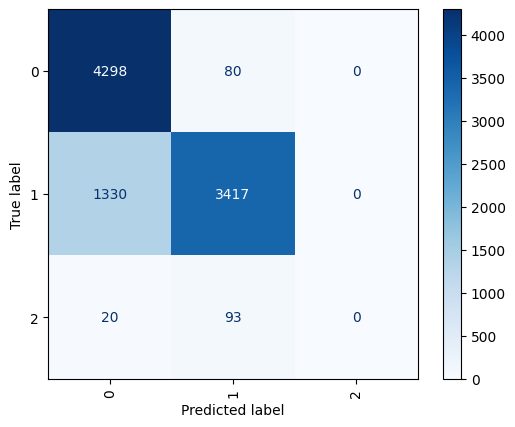

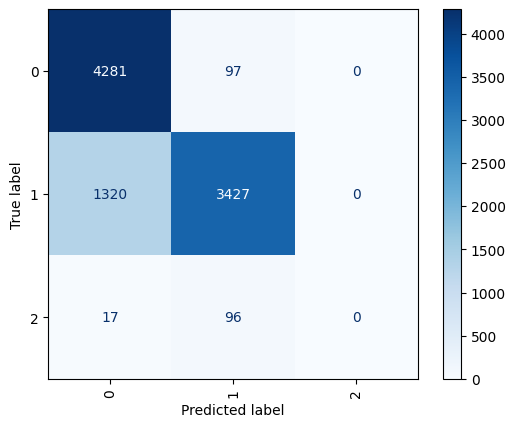

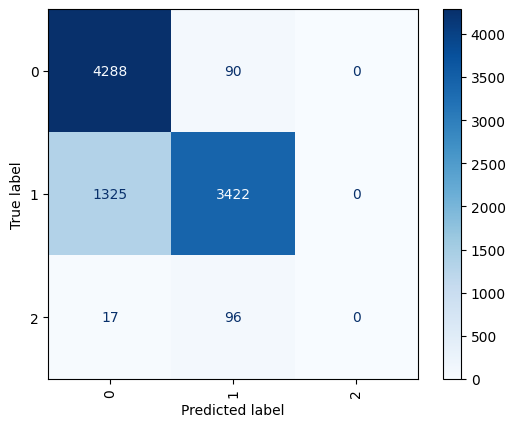

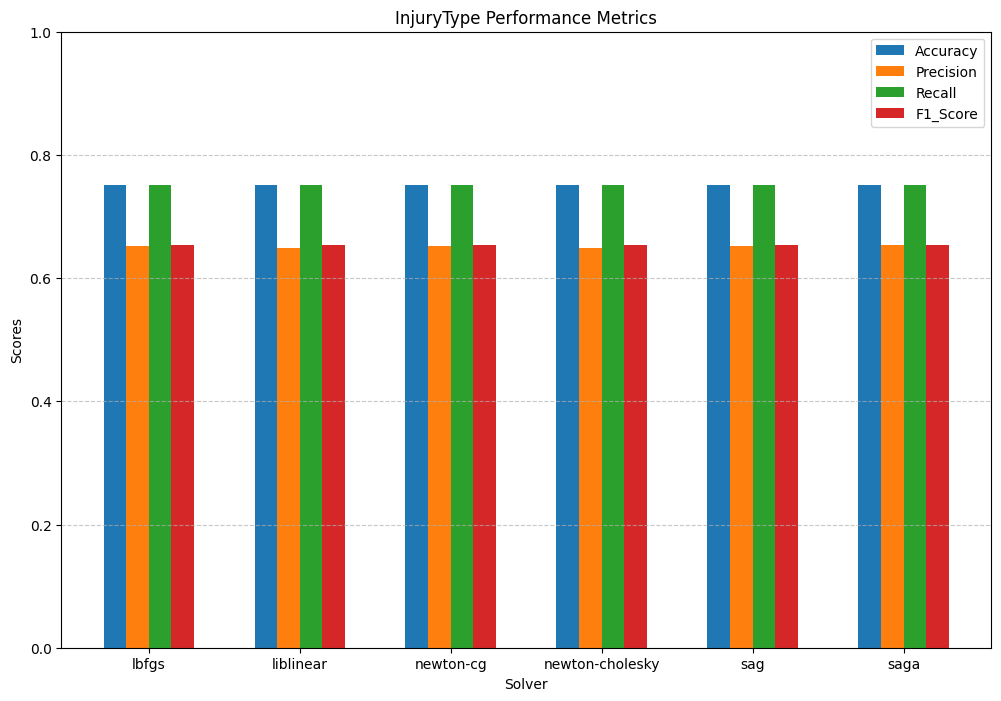

Confusion Matrix for Solver: lbfgs


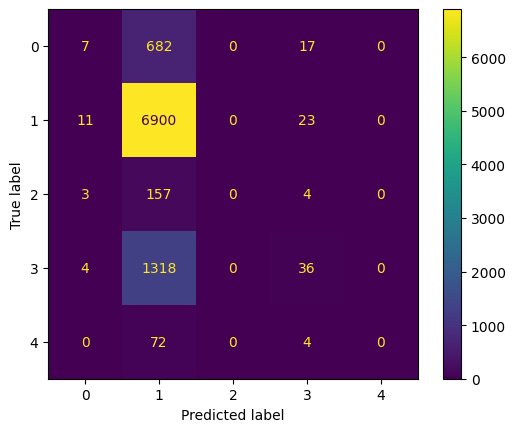

Confusion Matrix for Solver: liblinear


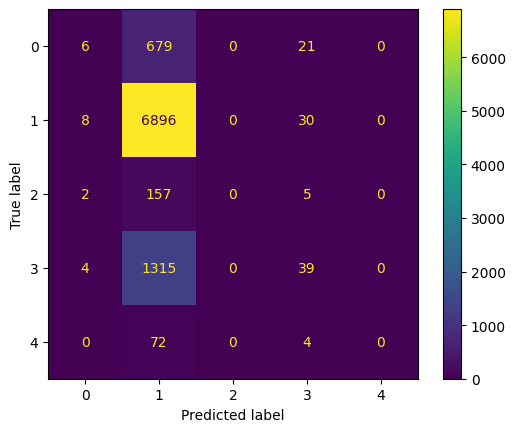

Confusion Matrix for Solver: newton-cg


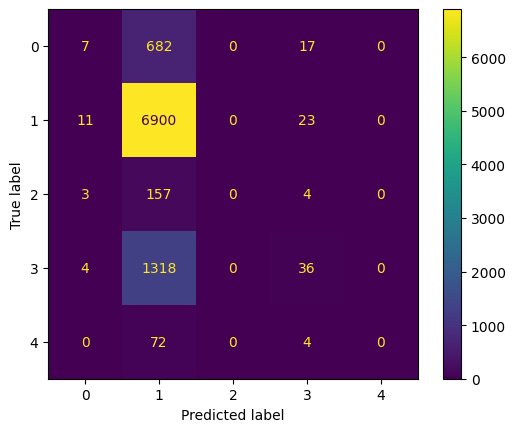

Confusion Matrix for Solver: newton-cholesky


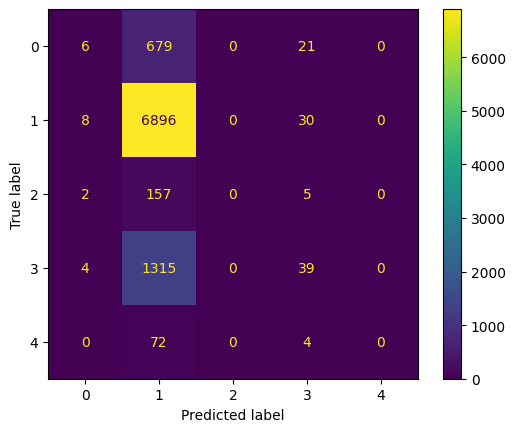

Confusion Matrix for Solver: sag


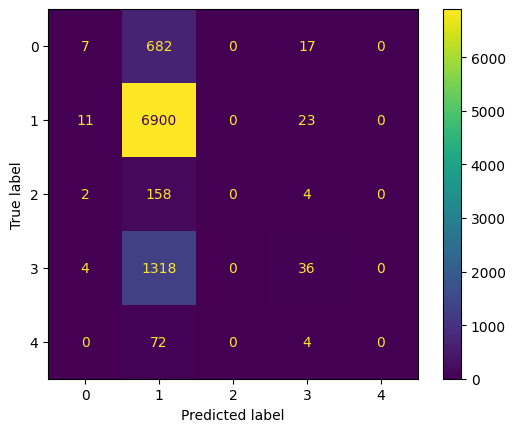

Confusion Matrix for Solver: saga


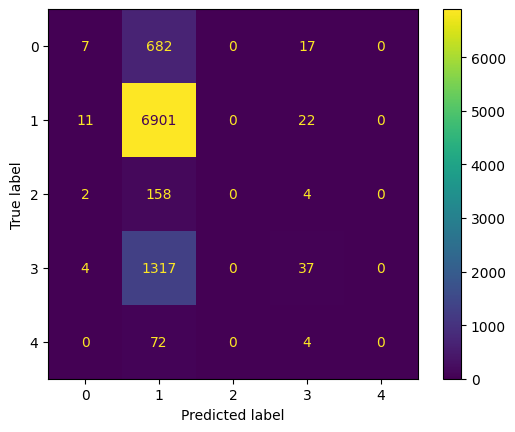

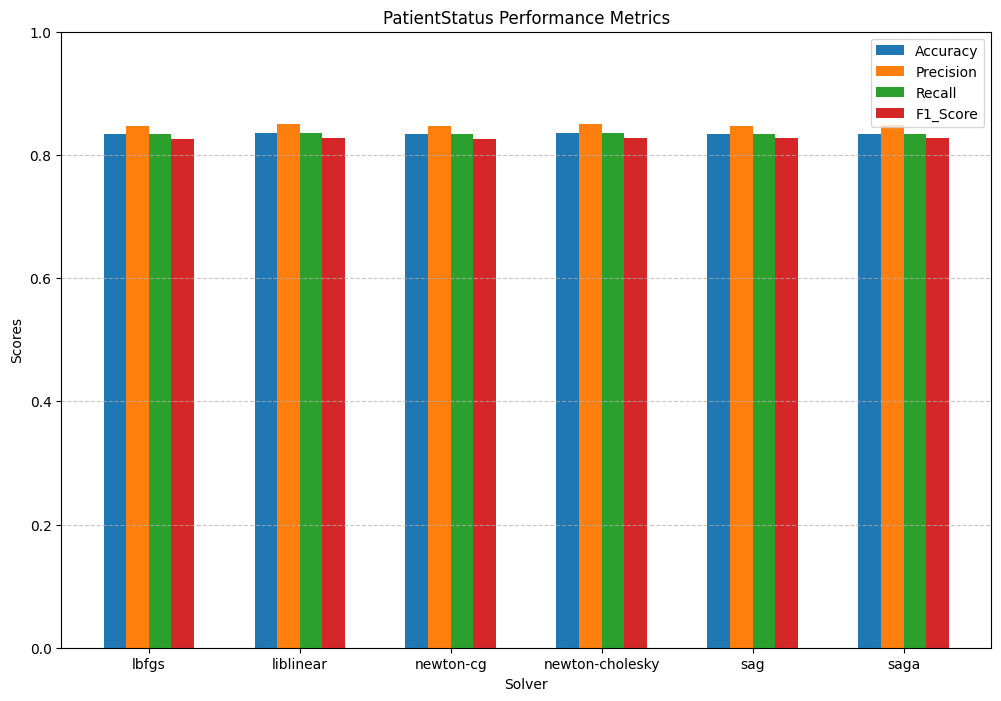

Confusion Matrix for Solver: lbfgs


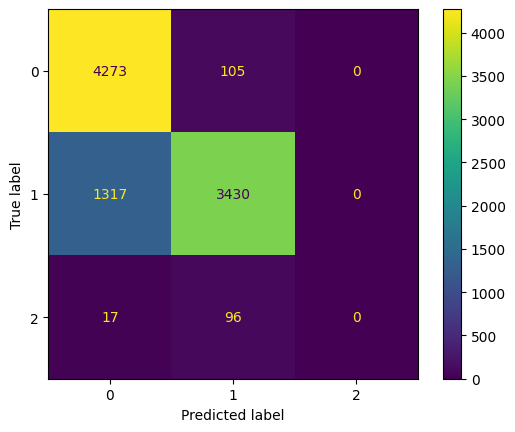

Confusion Matrix for Solver: liblinear


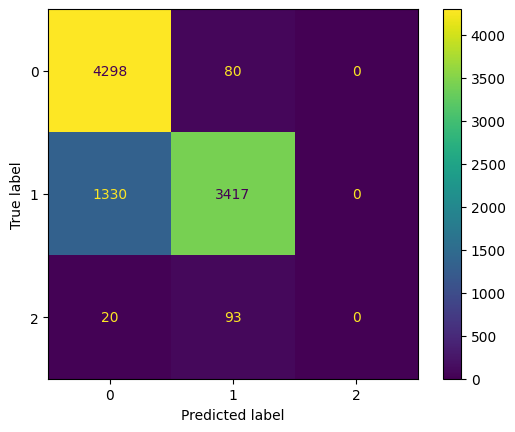

Confusion Matrix for Solver: newton-cg


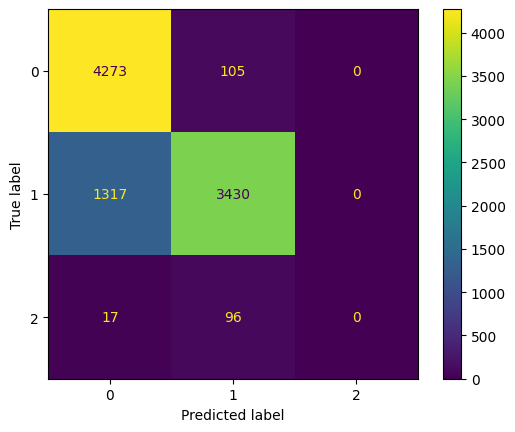

Confusion Matrix for Solver: newton-cholesky


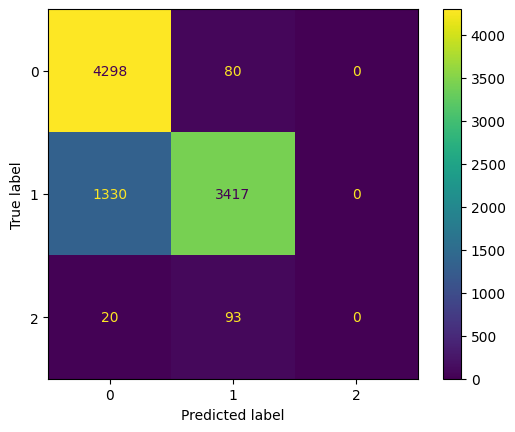

Confusion Matrix for Solver: sag


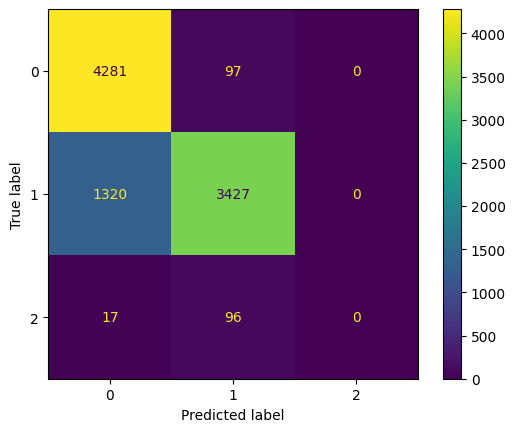

Confusion Matrix for Solver: saga


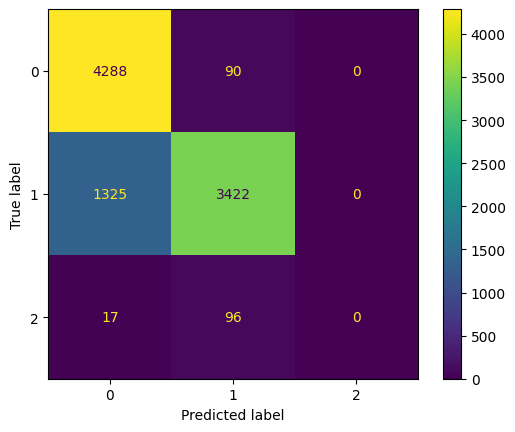

In [14]:
# Define target columns
target_cols = ['InjuryType', 'PatientStatus']

# For InjuryType model:
# Features (X) and target (y)
X_train_injury = train_set_encoded.drop(columns=target_cols)
y_train_injury = train_set_encoded['InjuryType']

X_test_injury = test_set_encoded.drop(columns=target_cols)
y_test_injury = test_set_encoded['InjuryType']

# For PatientStatus model:
# Features (X) and target (y)
X_train_status = train_set_encoded.drop(columns=target_cols)
y_train_status = train_set_encoded['PatientStatus']

X_test_status = test_set_encoded.drop(columns=target_cols)
y_test_status = test_set_encoded['PatientStatus']

# List of solvers to try
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

# Function to train and evaluate model with specified solver
def train_evaluate_model(solver, X_train, y_train, X_test, y_test):
    try:
        # Initialize model with the specified solver
        model = LogisticRegression(solver=solver, random_state=42)
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        # Create confusion matrix display
        confusion_display = ConfusionMatrixDisplay.from_estimator(
            model, X_test, y_test, cmap='Blues', xticks_rotation='vertical'
        )

        # Return results as a dictionary
        return {
            'Solver': solver,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
            'ConfusionDisplay': confusion_display
        }

    except Exception as e:
        # Capture the exception and include solver info
        error_message = f"Error with solver={solver}: {e}"
        print(error_message)
        return None

# Train and evaluate models for InjuryType with different solvers
results_injury = []
for solver in solvers:
    result = train_evaluate_model(solver, X_train_injury, y_train_injury, X_test_injury, y_test_injury)
    if result is not None:
        results_injury.append(result)

# Convert results to DataFrame for InjuryType
results_injury_df = pd.DataFrame([{
    k: v for k, v in result.items() if k != 'ConfusionDisplay'
} for result in results_injury])

# Train and evaluate models for PatientStatus with different solvers
results_status = []
for solver in solvers:
    result = train_evaluate_model(solver, X_train_status, y_train_status, X_test_status, y_test_status)
    if result is not None:
        results_status.append(result)

# Convert results to DataFrame for PatientStatus
results_status_df = pd.DataFrame([{
    k: v for k, v in result.items() if k != 'ConfusionDisplay'
} for result in results_status])

# Function to plot performance metrics using bar chart
def plot_metrics(metrics_df, title):
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
    solvers = metrics_df['Solver']
    num_metrics = len(metrics)
    
    plt.figure(figsize=(12, 8))
    bar_width = 0.15
    index = pd.Index(range(len(solvers)))

    # Plot each metric as a bar with some separation
    for i, metric in enumerate(metrics):
        plt.bar(index + i * bar_width, metrics_df[metric], width=bar_width, label=metric)

    plt.title(title)
    plt.xlabel('Solver')
    plt.ylabel('Scores')
    plt.xticks(index + (num_metrics - 1) * bar_width / 2, solvers)
    plt.ylim(0, 1)  # Set y-axis limit between 0 and 1
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot for InjuryType model
if not results_injury_df.empty:
    plot_metrics(results_injury_df, 'InjuryType Performance Metrics')
    # Plot confusion matrix for each solver
    for result in results_injury:
        print(f"Confusion Matrix for Solver: {result['Solver']}")
        result['ConfusionDisplay'].plot()
        plt.show()

# Plot for PatientStatus model
if not results_status_df.empty:
    plot_metrics(results_status_df, 'PatientStatus Performance Metrics')
    # Plot confusion matrix for each solver
    for result in results_status:
        print(f"Confusion Matrix for Solver: {result['Solver']}")
        result['ConfusionDisplay'].plot()
        plt.show()

**11. Experimenting with Different max_iter Values for All Solvers**

In [15]:
# Define solvers to experiment with
solvers = ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']

# Define max_iter values to experiment with
max_iters = [50, 100, 150, 200, 250, 300]

# Create all combinations of solvers and max_iter values
combinations = list(product(solvers, max_iters))

# Function to train and evaluate model with specified solver and max_iter
def train_evaluate_model(solver, max_iter, X_train, y_train, X_test, y_test, target_label):
    try:
        # Determine multi_class and penalty based on solver compatibility
        if solver == 'liblinear':
            # liblinear does not support 'multinomial' multi_class
            multi_class = 'ovr'
            penalty = 'l2'
        elif solver == 'newton-cholesky':
            # newton-cholesky requires 'l2' penalty
            multi_class = 'auto'  # Defaults to 'ovr' for binary, 'multinomial' for multiclass
            penalty = 'l2'
        else:
            multi_class = 'multinomial'
            penalty = 'l2'

        # Adjust n_jobs parameter based on solver
        n_jobs = -1 if solver in ['sag', 'saga'] else None

        # Initialize model with specified solver and max_iter
        model = LogisticRegression(
            solver=solver,
            max_iter=max_iter,
            random_state=42,
            n_jobs=n_jobs,
            penalty=penalty,
            multi_class=multi_class,
            # Setting class_weight to 'balanced' can help with class imbalance
            class_weight='balanced'
        )
        model.fit(X_train, y_train)

        # Make predictions
        y_pred = model.predict(X_test)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

        # Return results as a dictionary
        return {
            'Solver': solver,
            'Max_iter': max_iter,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1_Score': f1,
        }

    except Exception as e:
        # Capture the exception and include solver and max_iter info
        error_message = f"Error with solver={solver}, max_iter={max_iter} for {target_label}: {e}"
        print(error_message)
        return None

# Training and evaluating models for InjuryType
print("\nTraining models for InjuryType with different solvers and max_iter values...")
results_injury = []
for solver, max_iter in combinations:
    result = train_evaluate_model(solver, max_iter, X_train_injury, y_train_injury, X_test_injury, y_test_injury, 'InjuryType')
    if result is not None:
        results_injury.append(result)

# Convert results to DataFrame
results_injury_df = pd.DataFrame(results_injury)

# Training and evaluating models for PatientStatus
print("\nTraining models for PatientStatus with different solvers and max_iter values...")
results_status = []
for solver, max_iter in combinations:
    result = train_evaluate_model(solver, max_iter, X_train_status, y_train_status, X_test_status, y_test_status, 'PatientStatus')
    if result is not None:
        results_status.append(result)

# Convert results to DataFrame
results_status_df = pd.DataFrame(results_status)


Training models for InjuryType with different solvers and max_iter values...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef


Training models for PatientStatus with different solvers and max_iter values...


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

**12. Analyzing Results and Plotting Learning Curves**

**a. Identifying the Best Models**

In [16]:
# Function to identify the best model based on accuracy
def get_best_model(results_df, target_label):
    best_model = results_df.loc[results_df['Accuracy'].idxmax()]
    print(f"\nBest {target_label} Model:")
    print(f"Solver: {best_model['Solver']}")
    print(f"Max_iter: {best_model['Max_iter']}")
    print(f"Accuracy: {best_model['Accuracy']:.4f}")
    print(f"Precision: {best_model['Precision']:.4f}")
    print(f"Recall: {best_model['Recall']:.4f}")
    print(f"F1 Score: {best_model['F1_Score']:.4f}")
    return best_model

# Get the best model for InjuryType
best_injury = get_best_model(results_injury_df, 'InjuryType')

# Get the best model for PatientStatus
best_status = get_best_model(results_status_df, 'PatientStatus')


Best InjuryType Model:
Solver: liblinear
Max_iter: 50
Accuracy: 0.6533
Precision: 0.6846
Recall: 0.6533
F1 Score: 0.6612

Best PatientStatus Model:
Solver: liblinear
Max_iter: 50
Accuracy: 0.8322
Precision: 0.8540
Recall: 0.8322
F1 Score: 0.8265


**b. Plotting Learning Curves**

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


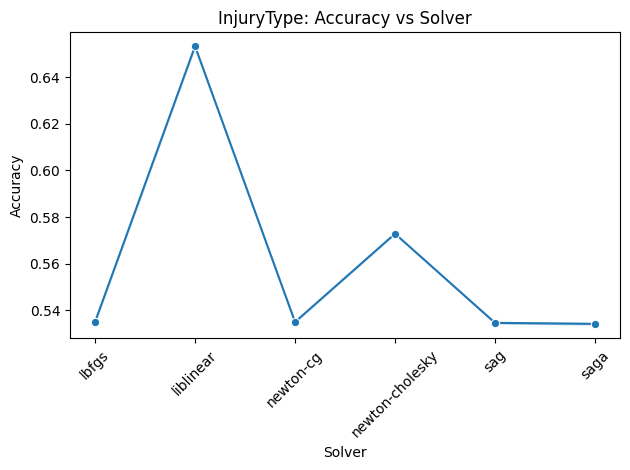

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


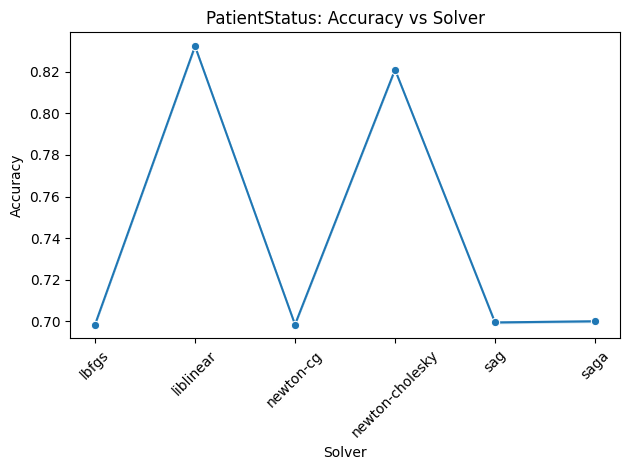

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


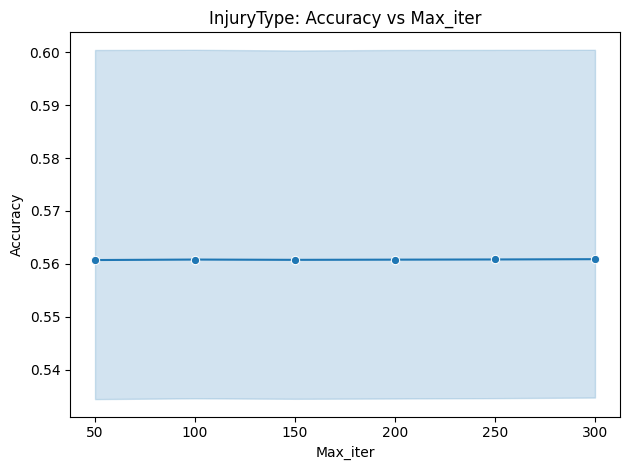

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


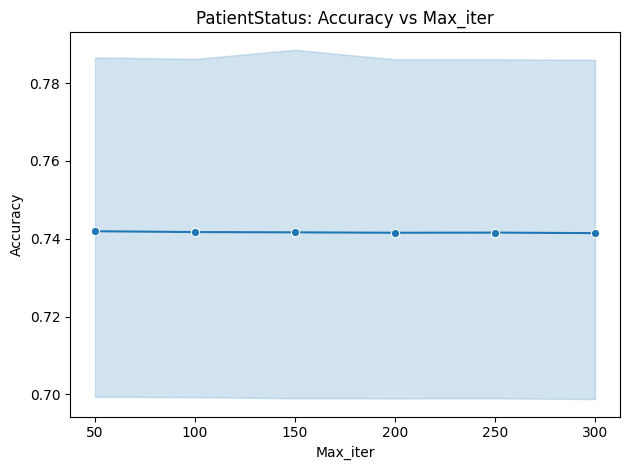

In [17]:
# Plotting Accuracy vs Solver

# For InjuryType
plt.figure()
sns.lineplot(data=results_injury_df, x='Solver', y='Accuracy', marker='o')
plt.title('InjuryType: Accuracy vs Solver')
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# For PatientStatus
plt.figure()
sns.lineplot(data=results_status_df, x='Solver', y='Accuracy', marker='o')
plt.title('PatientStatus: Accuracy vs Solver')
plt.xlabel('Solver')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plotting Accuracy vs Max_iter

# For InjuryType
plt.figure()
sns.lineplot(data=results_injury_df, x='Max_iter', y='Accuracy', marker='o')
plt.title('InjuryType: Accuracy vs Max_iter')
plt.xlabel('Max_iter')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()

# For PatientStatus
plt.figure()
sns.lineplot(data=results_status_df, x='Max_iter', y='Accuracy', marker='o')
plt.title('PatientStatus: Accuracy vs Max_iter')
plt.xlabel('Max_iter')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()